This notebook gives a brief tutorial on how to use paarti to calculate Strehl for some real on-sky data. Paarti uses the poppy physical optics python package to generate a perfect diffraction limited PSF, based on an internally defined of a Keck aperture. 

In [4]:
from paarti import psfs
from paarti.utils import keck_utils
from paarti.psf_metrics import metrics
from astropy.io import fits
import glob
import numpy as np
import astropy.units as u
import poppy
import matplotlib.pyplot as plt

# The Keck Aperture

The paarti Keck aperture includes segment spacing, the spider structures and the full size of the obscuration by the secondary mirror mouunt. Let's take a look. 


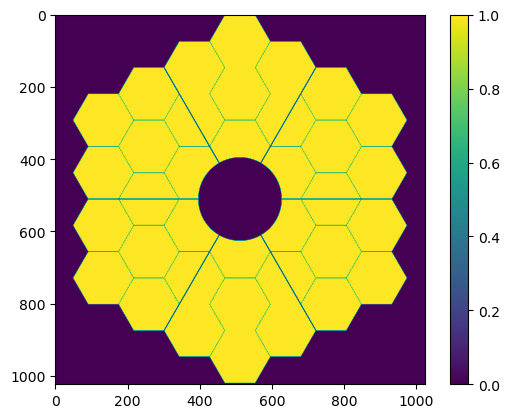

In [5]:
#First we need to setup a wavefrontobject. 
diam = 11 * u.m # This will be the diameter of the wavefront object, not the pupil itself (which is closer to 10.9m on its longest side. 
temp_wavefront = poppy.Wavefront(wavelength=2*u.micron, npix=1024, diam=diam) #The wavefront object we need to pass to the Optic object that defines the pupil. #The wavelength doesn't actually matter here. 

#Get the pupil optic
keck_pupil = keck_utils.make_keck_poppy_pupil()
#Pass the wavefront object through the pupil to get the transmission. 
ampl = keck_pupil.get_transmission(temp_wavefront)
transmittance = ampl**2

#Plot it
plt.imshow(transmittance)
plt.colorbar()

# Make a Keck Diffraction Limited PSF

To generate the diffraction limited PSF, we just need to generate this aperture and propagate a wavefront to a detector plane. 

In [6]:
#Create a poppy optical system and define our pupil
osys = poppy.OpticalSystem()
osys.add_pupil(keck_utils.make_keck_poppy_pupil())  

#Add a detector, where the platescale and field of view of our final image plane is defined. 
pix_scale = 0.0065*u.arcsec/u.pixel #Here we'll use the pixel scale for the ORKID camera at Keck
fov = 3*u.arcsec #This is probably bigger than we need. 
osys.add_detector(pixelscale=pix_scale, fov_arcsec=fov)

#Calculate the PSF at the detector plane for a given wavelength. 
wavelength = 656e-9 #Let's pick the H-alpha wavelength TO CONFIRM
psf = osys.calc_psf(wavelength)   #This is output as an astropy hdu list. 

Let's plot it now. 

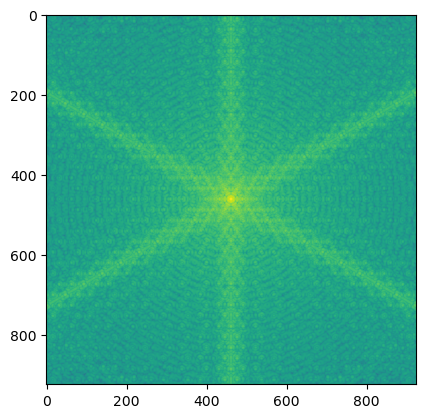

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(psf[0].data,norm=LogNorm())

### Simplifed

All this can be done behind the scenes using the `generate_keck_psf` function, which outputs a astropy hdu list. 

In [8]:
keck_psf = keck_utils.generate_keck_psf(656e-9,0.0065)

Now we need to save this to a fits file in order to read it in to the `calc_strehl` function, which expects a `PIXSCALE` header keyword, set here. 

In [9]:
keck_psf[0].header['PIXSCALE'] = pix_scale.value
psf_filename = "Halpha_psf.fits"
keck_psf.writeto(psf_filename,overwrite=True)

# Now we can read in some data to analyze. 

Read in the psf files

In [10]:
datadir = "/Users/maxwellmb/Data/ORKID/230802/"
filelist = sorted(glob.glob(datadir+"*.fits"))
print("Found {} files".format(len(filelist)))

data = []
for filename in filelist: 
    data.append(fits.getdata(filename)-np.median(fits.getdata(filename)))
data = np.array(data)

Found 5 files


Put them in the paarti `PSF_stack` structure and add the diameter property

In [12]:
psf_wavelength = wavelength*1e9 #We want it in nm here. 
filter_bw = 10 #the bandwidth of the filter in nm
pos = np.zeros([len(filename),2]) #PSF_stack wants the field position of the PSFs. In this case we don't use this and can just assume they're all centered. 
psf_list = psfs.PSF_stack(data,pos,pix_scale.value,psf_wavelength,filter_bw,'Keck2')
psf_list.telescope_diam = 10.949

# Finally, calculate the strehl ratios for each image

Here you input your psf_list, the filename to your perfect diffraction limited psf and an aperture size that describes how much of the image you want to use in the (peak flux)/(aperture sum) calculation (and in background estimation). 

In [18]:
from paarti.psf_metrics import strehl
strehl.calc_strehl(psf_list,dl_img_file=psf_filename,aper_size=0.3)

Calculating strehls of PSFs in PSF stack


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 22.45it/s]


Print them out! 

In [19]:
print(psf_list.psf_strehls)

[0.00804704 0.00614888 0.00759043 0.00775631 0.00808026]


Ok, well this is very low Strehl data, and so it's up to you whether you believe these numbers in this specific case, but now you know how to use `paarti` to make these calculations!